<a href="https://colab.research.google.com/github/gizemkaratas/Miuul_ML_FinalProjesi/blob/main/asist_BitirmeProjesi_miuul.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Makine Öğrenmesi ile Futbol Maç Sonucu Tahminlemesi**

## **Projenin Konusu ve Hedefi**


---


*  Bu projede, futbol maçlarında oyuncuların sarı kart görme olasılığını etkileyen faktörler analiz edilerek gelecekteki maçlar için sarı kart tahminleme modeli oluşturulmuştur.

*  **Proje, 03.08.2024 tarihinde gerçekleşen Süper Kupa Final Maçı olan GS-BJK maçında alınacak sonuçların tahmininde kullanılmıştır.**



**Gerekli Kütüphanelerin Yüklenmesi ve Ayarların Yapılması**

---



In [ ]:
# Eksik modülleri yükle
!pip install xgboost
!pip install imbalanced-learn

# Gerekli kütüphaneleri içe aktar
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, mean_squared_error, mean_absolute_error
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
from sklearn.exceptions import ConvergenceWarning
import warnings
pd.set_option('display.width', 1000)
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: "%.3f" % x)

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 1.8 MB/s eta 0:00:00


**Veri Setlerinin Yüklenmesi ve Dataframe Düzenlenmesi**

* 9 farklı veri seti kullanıldı, gerekli olan değişkenler alındı, yeni değişkenler eklendi, aykırı değerler ve nan değerler düzeltildi, modelin eğitilmesi için gereken tüm işlemler tamamlanarak yeni bir csv dosyası oluşturuldu.
* Veri setinin ham hali bu bağlantıda bulunmaktadır: [bağlantı metni](https://www.kaggle.com/datasets/davidcariboo/player-scores/data)

* Eklenen değişkenler: Last_20, first_20, Attendance_rate, referee_card_avg, experience, minutes_in_last_4_matches, player_card_avg

---





In [ ]:
#Veriler içinden birleştirme yapacağım ortak sütunları ve işleme sokacağım sütunları okutup eksik verileri çıkardım
app = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/archive (6)/appearances.csv")
app = app.loc[:, ["game_id", 'date', 'player_id',"yellow_cards", 'minutes_played', 'red_cards', 'player_club_id']]
app = app.rename(columns={"player_club_id": "club_id"})
app['date'] = pd.to_datetime(app['date'])

pl = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/archive (6)/players.csv")
pl = pl.loc[:, ['player_id', 'date_of_birth', 'position']]
pl['date_of_birth'] = pd.to_datetime(pl['date_of_birth'])
pl = pl.dropna()

g = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/archive (6)/games.csv")
g = g.loc[:, ['game_id', 'stadium', 'attendance', 'referee', 'competition_type',]]
g = g.dropna()

ge = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/archive (6)/game_events.csv", parse_dates=["date"])
ge = ge.loc[:, ['game_id','date', 'minute', 'type',
       'player_id', 'description']]
ge = ge.dropna()

gl = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/archive (6)/game_lineups.csv")
gl = gl.loc[:,["game_id", "player_id", "type", "team_captain"]]
# Oyuncuların maça başlama durumunu belirtme
gl['type'] = gl['type'].map({'starting_lineup': 1, 'substitutes': 0})
gl = gl.rename(columns={"type": "starting"})

cl = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/archive (6)/clubs.csv")
cl = cl.loc[:, ['stadium_name', 'stadium_seats']]

#Birleştirme için ortak sütunda isim değişikliği
cl = cl.rename(columns={"stadium_name": "stadium"})
#Clubs veri setinde bazı stadyumların kapasitesi 2 farklı değerde gösterilmiş. Bunlardan büyük olanını aldıp diğer değeri sildim
max_capacity_df = cl.groupby('stadium')['stadium_seats'].max().reset_index()
cl = cl.merge(max_capacity_df, on='stadium', how='inner', suffixes=('', '_max'))
cl = cl.drop_duplicates(subset=['stadium', 'stadium_seats_max'])

cl_g = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/archive (6)/club_games.csv")
cl_g = cl_g.loc[:, ['game_id', 'hosting', 'club_id']]
# hosting değişkenlerindenki Home ve Away değerlerini 1 ve 0'a dönüştür
cl_g["hosting"] = cl_g["hosting"].map({"Home": 1, "Away": 0})


#Verileri ortak sütunda birleştirme işlemleri
df = pd.merge(ge, g, on='game_id', how='inner')
df = pd.merge(df, pl, on='player_id', how='inner')
df = pd.merge(df, gl, on=["game_id", "player_id"], how='inner')
df = df.merge(app, on=['game_id', "date", "player_id"], how='inner')
df = pd.merge(df, cl_g, on=['game_id', 'club_id'], how='inner')
df = df.merge(cl, on='stadium', how='inner')

#Verideki hatalı veya sorun çıkara kısımların çıkarılması
df = df[df["minute"] >= 0 ]
df = df[~(df["position"] == "Missing")]
df["attendance"] = df["attendance"].astype("int")



#Oyuncunun maç oynandığı tarihteki yaşının hesaplanması
df['age'] = df['date'].dt.year - df['date_of_birth'].dt.year

df = df.sort_values(by=['player_id', 'age'])

#Type ve minute (olay ve gerçekleştiği dakika) sütunları kullanılarak sarı kartların maçın ilk 20, son 20 ve
# uzatma dakikalarında görülmesine göre 3 yeni değişken eklenmesi
df["last_20"] = [1 if ((i[2] >= 70 and i[2] <= 90) & (i[3] == "Cards")) else 0 for i in df.values]
df["first_20"] = [1 if ((i[2] <= 20 ) & (i[3] == "Cards")) else 0 for i in df.values]
#df["extras"] = [1 if ((i[2] > 90 ) & (i[3] == "Cards")) else 0 for i in df.values]

#Seyirci sayısı ve stadyum kapasitesi üzerinde doluluk oranı hesaplanması
df["attendance_rate"] = (df["attendance"] * 100) / df["stadium_seats_max"]

#Doluluk oranının makul seviyelere çekilmesi
df = df[df["attendance_rate"] <= 100.0]

#Maçlara atanan hakemlerin kart performansı hesabı ve veriyle birleştirilmesi
referee_card_avg = df.groupby('referee')['yellow_cards'].mean().reset_index()
referee_card_avg.columns = ['referee', 'referee_card_avg']
df = df.merge(referee_card_avg, on='referee', how='inner')

#Maçların önemine göre değer ataması yapılması uluslararası > kupa > yerel lig
importance_mapping = {
    'domestic_league': 1,
    'domestic_cup': 2,
    'international_cup': 3,
    'others': 0
}

df['importance'] = df['competition_type'].apply(lambda x: importance_mapping.get(x, 0))



#Maçlarda sahada olan oyuncuncuların yaşlarına göre deneyim değeri ataması 15-23 1, 24-33 2, 34+ 3
bins = [15, 24, 33, 42]
labels = [1, 2, 3]
df['experience'] = pd.cut(df['age'], bins=bins, labels=labels, right=True, include_lowest=True)
df['experience'] = df['experience'].astype('int')

player_id_counts = df["player_id"].value_counts()
valid_player_ids = player_id_counts[player_id_counts >= 12].index
df = df[df["player_id"].isin(valid_player_ids)]

df['minutes_in_last_4_matches'] = df.groupby('player_id')['minute'].rolling(window=4, min_periods=1).sum().reset_index(level=0, drop=True)
df['minutes_in_last_4_matches'] = df['minutes_in_last_4_matches'].astype(int)

# Her maç için toplam kart sayısını hesaplama
total_cards_per_game = df.groupby('game_id').agg({'yellow_cards': 'sum', 'red_cards': 'sum'}).reset_index()
total_cards_per_game['total_cards_in_game'] = total_cards_per_game['yellow_cards'] + total_cards_per_game['red_cards']
# Orijinal veri setine toplam kart sayısını ekleme
df = df.merge(total_cards_per_game[['game_id', 'total_cards_in_game']], on='game_id')

# Oyuncunun toplam sarı kart sayısını hesaplama
total_yellow_cards_per_player = df.groupby('player_id')['yellow_cards'].sum().reset_index()
total_yellow_cards_per_player.columns = ['player_id', 'total_yellow_cards']

# Oyuncunun oynadığı maç sayısını hesaplama
games_per_player = df.groupby('player_id')['game_id'].nunique().reset_index()
games_per_player.columns = ['player_id', 'games_played']

# Bu bilgileri orijinal veri setine ekleme
df = df.merge(total_yellow_cards_per_player, on='player_id')
df = df.merge(games_per_player, on='player_id')

# Oyuncunun maç başına gördüğü sarı kart oranını hesaplama
df['player_card_av'] = df['total_yellow_cards'] / df['games_played']

# Gereksiz sütunları kaldırma
df = df.drop(columns=['total_yellow_cards', 'games_played'])
df.drop_duplicates(inplace=True)


#Hesap yapmada kullanılan ve gereksiz görülen sütunların temizlenmesi
df = df.drop(['game_id', 'date', 'type', 'minute','description', 'date_of_birth','stadium_seats',
       'stadium_seats_max', 'competition_type', 'stadium', 'red_cards', 'club_id'], axis=1)
df.to_csv('asist.csv', index=False)

In [ ]:
 # Aşama 1: Veri setinin yüklenmesi

df = pd.read_csv("asist.csv")
# Zaman ölçümüne başlama
start_time = time.time()
print(f"Aşama 1: Veri yüklendi ({time.time() - start_time:.2f} saniye)")

Aşama 1: Veri yüklendi (0.00 saniye)


**Veri İnceleme**

---



In [ ]:
print(df.dropna())
def veri_inceleme(df):
    print("\nDataframe'in ilk 5 tanesi")
    print(df.head())
    print("\n\nDataframe'in columnları")
    print(df.columns)
    print("\n\nDataframe hakkında istatistiksel bilgi")
    print(df.describe())
    print("/Column Sayısı:")
    print(df.shape)
    print("\n\nDataframe hakkındaki bilgileri verir")
    print(df.info())
    print("\n\nDataframe'deki boş girilen hücreleri gösterir")
    print(df.isnull().sum())
veri_inceleme(df)

        player_id  attendance             referee  position  starting  team_captain  yellow_cards  minutes_played  hosting  age  last_20  first_20  attendance_rate  referee_card_avg  importance  experience  minutes_in_last_4_matches  total_cards_in_game  player_card_av
0              10       24556    Andrea Gervasoni    Attack         1             0             0              83        1   35        0         0           33.519             0.402           1           3                         83                    4           0.233
1              10       22531    Andrea Gervasoni    Attack         1             0             0              78        0   38        0         0           61.958             0.402           1           3                         93                    0           0.233
2              10       22531    Andrea Gervasoni    Attack         1             0             0              78        0   38        0         0           61.958             0.402         

**Veri Düzenleme**

---



In [ ]:
# df veri setinden game_id, player_id, clup_id, değişkenlerini çıkart
df = df.drop(['player_id', 'referee', 'importance', 'experience', 'total_cards_in_game', 'importance', 'experience', 'last_20', 'first_20'], axis=1)


In [ ]:
# one-hot encoding (position, type, season, home_club_formation, away_club_formation)
df = pd.get_dummies(df, columns=['position', 'starting', 'team_captain', 'hosting',])

In [ ]:
# yellow_cards değişkeninin sınıf sayılarını ve oranlarını görüntüle
print(df["yellow_cards"].value_counts())
print(df["yellow_cards"].value_counts(normalize=True))


df.isnull().sum()

# hedef değişken sınıfının değerlerindeki dengesizliği giderme
df = df.drop(df[df["yellow_cards"] == 0].sample(frac=0.30, random_state=42).index)

yellow_cards
0    91687
1    37442
2     1452
Name: count, dtype: int64
yellow_cards
0   0.702
1   0.287
2   0.011
Name: proportion, dtype: float64


In [ ]:
df.to_csv("model_verisi.csv", index=False)

In [ ]:
# Aşama 2: 'yellow_cards' değişkenindeki 2 olan değerleri 1 olarak değiştirme
print("Aşama 2: Hedef değişken dönüştürülüyor...")
start_time = time.time()
df["yellow_cards"] = df["yellow_cards"].replace({2: 1})
print(f"Aşama 2: Hedef değişken dönüştürüldü ({time.time() - start_time:.2f} saniye)")

Aşama 2: Hedef değişken dönüştürülüyor...
Aşama 2: Hedef değişken dönüştürüldü (0.00 saniye)


In [ ]:
# Aşama 3: Bağımsız değişkenler (X) ve hedef değişkeni (y) ayırma
print("Aşama 3: Özellikler ve hedef ayrılıyor...")
start_time = time.time()
X = df.drop("yellow_cards", axis=1)
y = df["yellow_cards"]
print(f"Aşama 3: Özellikler ve hedef ayrıldı ({time.time() - start_time:.2f} saniye)")

Aşama 3: Özellikler ve hedef ayrılıyor...
Aşama 3: Özellikler ve hedef ayrıldı (0.01 saniye)


**Kategorik Değişkenlerin Belirlenmesi**

---





In [ ]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]
    print(f"Gözlemler: {dataframe.shape[0]}")
    print(f"Değişkenler: {dataframe.shape[1]}")
    print(f'Kategorik Sütunlar: {len(cat_cols)}')
    print(f'Sayısal Sütunlar: {len(num_cols)}')
    print(f'Yüksek Kardinaliteli Kategorik Sütunlar: {len(cat_but_car)}')
    print(f'Sayısal Görünen Kategorik Sütunlar: {len(num_but_cat)}')
    return cat_cols, cat_but_car, num_cols

cat_cols, cat_but_car, num_cols = grab_col_names(df)

Gözlemler: 103075
Değişkenler: 17
Kategorik Sütunlar: 10
Sayısal Sütunlar: 7
Yüksek Kardinaliteli Kategorik Sütunlar: 0
Sayısal Görünen Kategorik Sütunlar: 10


**Değişken Analizi**

---



              HEDEF_ORTALAMA
yellow_cards                
0                      0.000
1                      1.000


                 HEDEF_ORTALAMA
position_Attack                
False                     0.488
True                      0.269


                   HEDEF_ORTALAMA
position_Defender                
False                       0.335
True                        0.590


                   HEDEF_ORTALAMA
position_Midfield                
False                       0.348
True                        0.436


            HEDEF_ORTALAMA
starting_0                
False                0.379
True                 0.362


            HEDEF_ORTALAMA
starting_1                
False                0.362
True                 0.379


                HEDEF_ORTALAMA
team_captain_0                
False                    0.430
True                     0.373


                HEDEF_ORTALAMA
team_captain_1                
False                    0.373
True                     0.430


    

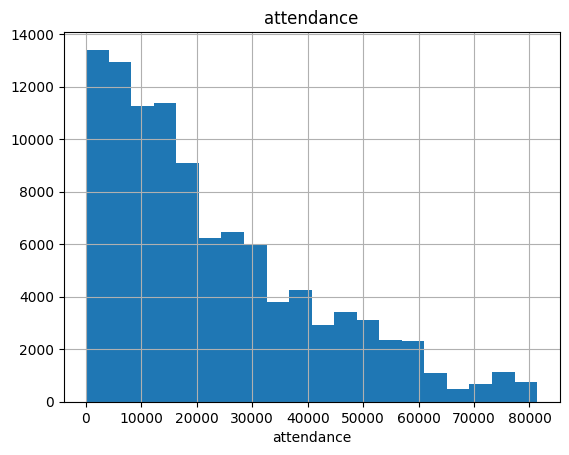

count   103075.000
mean        77.098
std         20.001
min          1.000
5%          27.000
10%         45.000
20%         66.000
30%         75.000
40%         82.000
50%         88.000
60%         90.000
70%         90.000
80%         90.000
90%         90.000
95%         90.000
99%         90.000
max        120.000
Name: minutes_played, dtype: float64


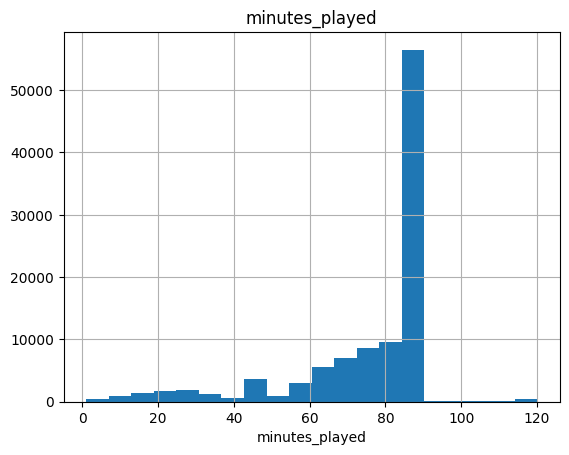

count   103075.000
mean        26.698
std          3.987
min         17.000
5%          21.000
10%         22.000
20%         23.000
30%         24.000
40%         25.000
50%         26.000
60%         28.000
70%         29.000
80%         30.000
90%         32.000
95%         34.000
99%         36.000
max         42.000
Name: age, dtype: float64


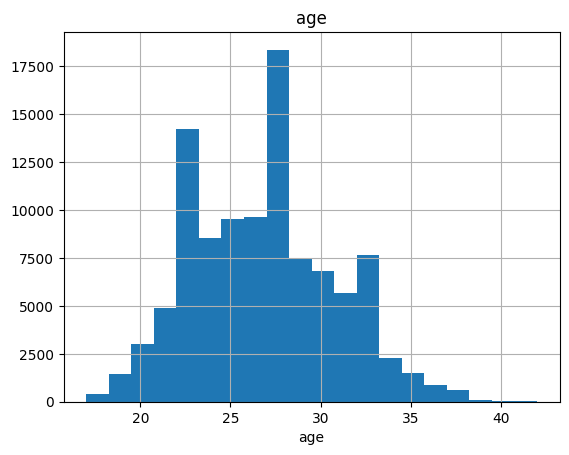

count   103075.000
mean        65.637
std         27.464
min          0.069
5%          14.865
10%         24.059
20%         38.410
30%         50.581
40%         61.028
50%         70.807
60%         79.434
70%         87.121
80%         93.789
90%         97.852
95%         99.384
99%        100.000
max        100.000
Name: attendance_rate, dtype: float64


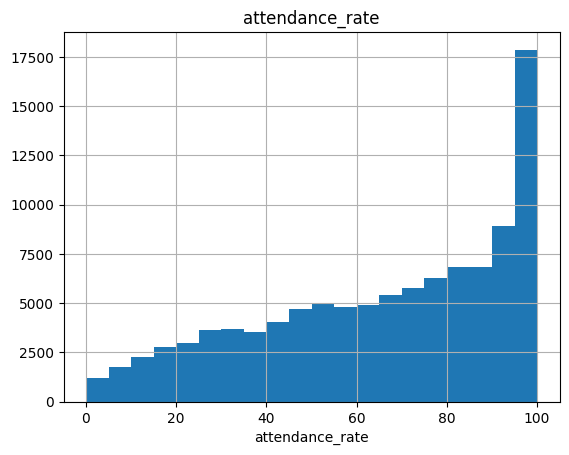

count   103075.000
mean         0.333
std          0.086
min          0.000
5%           0.214
10%          0.247
20%          0.264
30%          0.284
40%          0.305
50%          0.332
60%          0.351
70%          0.365
80%          0.396
90%          0.435
95%          0.483
99%          0.594
max          1.100
Name: referee_card_avg, dtype: float64


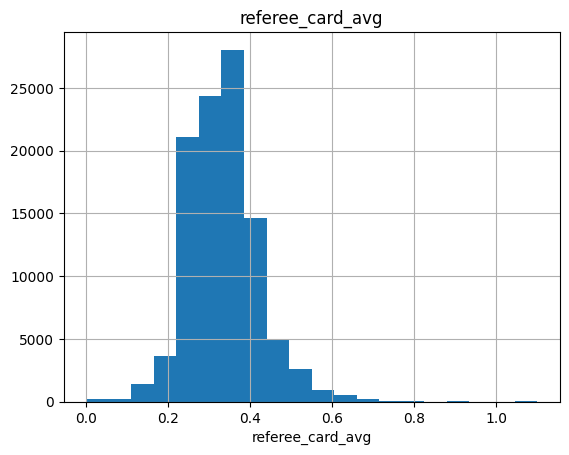

count   103075.000
mean       213.657
std         63.110
min          1.000
5%          90.000
10%        130.000
20%        165.000
30%        187.000
40%        205.000
50%        220.000
60%        235.000
70%        251.000
80%        267.000
90%        289.000
95%        305.000
99%        330.000
max        454.000
Name: minutes_in_last_4_matches, dtype: float64


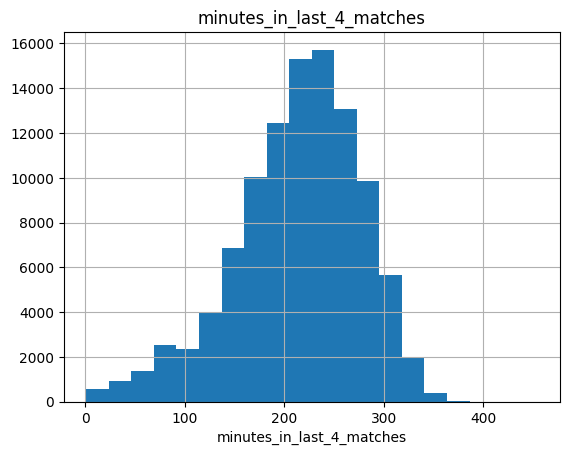

count   103075.000
mean         0.385
std          0.255
min          0.000
5%           0.074
10%          0.111
20%          0.167
30%          0.220
40%          0.269
50%          0.333
60%          0.397
70%          0.474
80%          0.586
90%          0.737
95%          0.875
99%          1.182
max          2.125
Name: player_card_av, dtype: float64


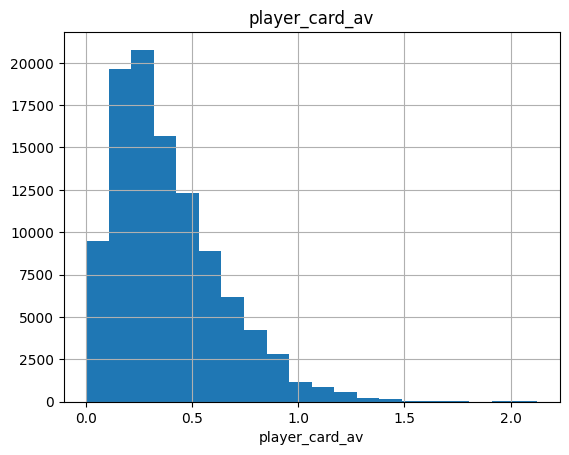

              yellow_cards  Ratio
yellow_cards                     
0                    64181 62.266
1                    38894 37.734
##########################################


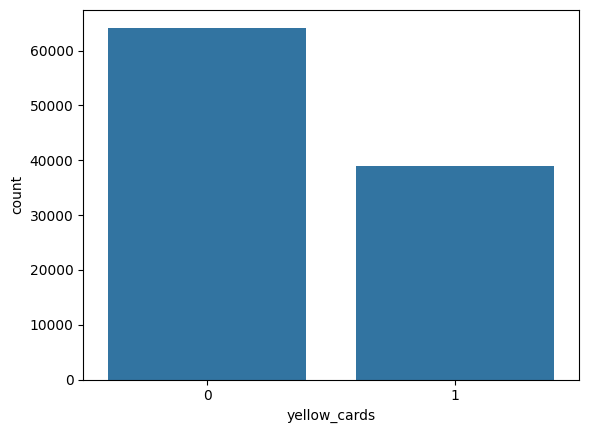

                 position_Attack  Ratio
position_Attack                        
True                       52033 50.481
False                      51042 49.519
##########################################


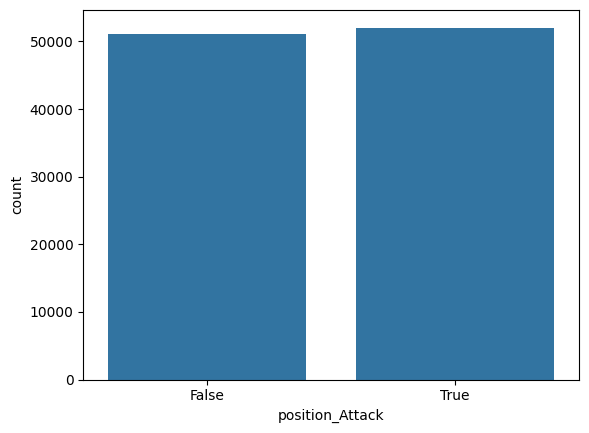

                   position_Defender  Ratio
position_Defender                          
False                          85972 83.407
True                           17103 16.593
##########################################


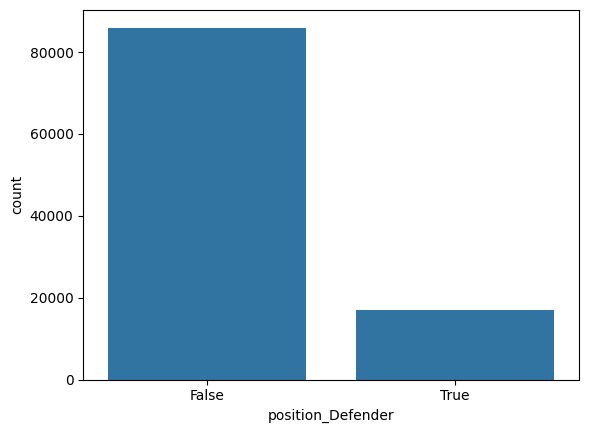

                   position_Midfield  Ratio
position_Midfield                          
False                          69136 67.073
True                           33939 32.927
##########################################


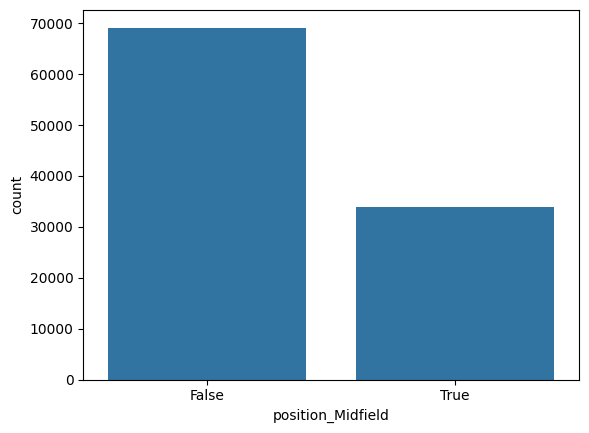

            starting_0  Ratio
starting_0                   
False            94300 91.487
True              8775  8.513
##########################################


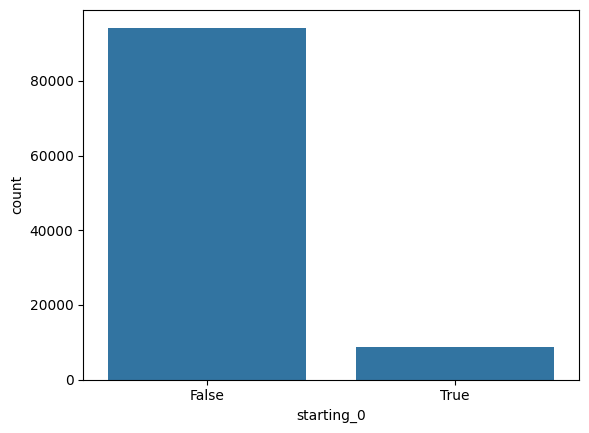

            starting_1  Ratio
starting_1                   
True             94300 91.487
False             8775  8.513
##########################################


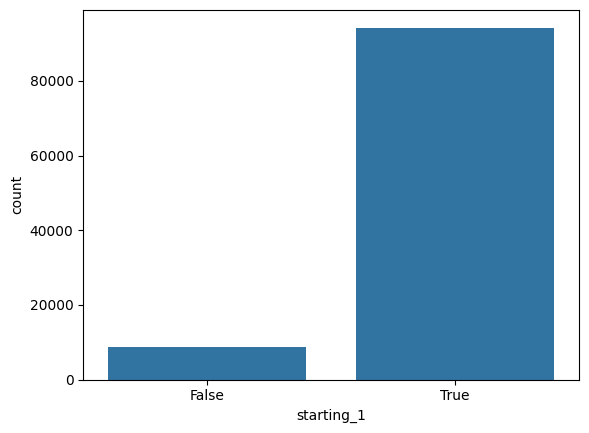

                team_captain_0  Ratio
team_captain_0                       
True                     95557 92.706
False                     7518  7.294
##########################################


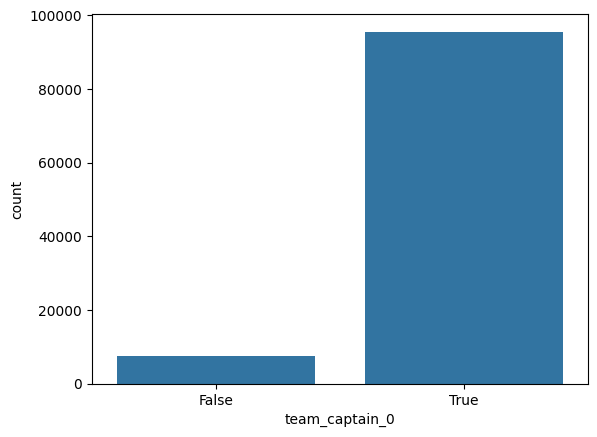

                team_captain_1  Ratio
team_captain_1                       
False                    95557 92.706
True                      7518  7.294
##########################################


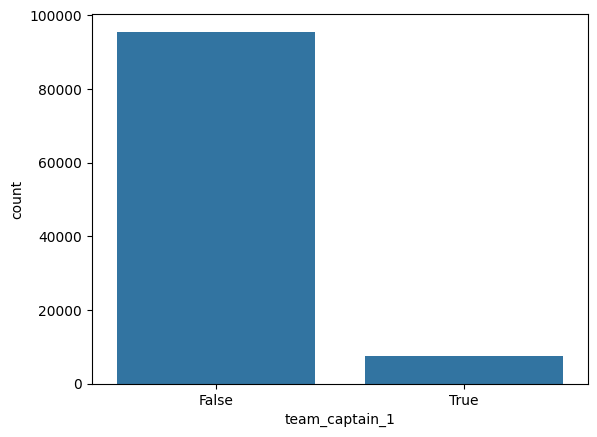

           hosting_0  Ratio
hosting_0                  
False          55588 53.930
True           47487 46.070
##########################################


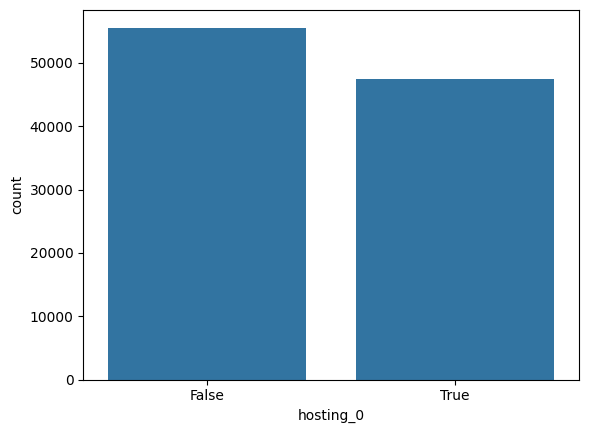

           hosting_1  Ratio
hosting_1                  
True           55588 53.930
False          47487 46.070
##########################################


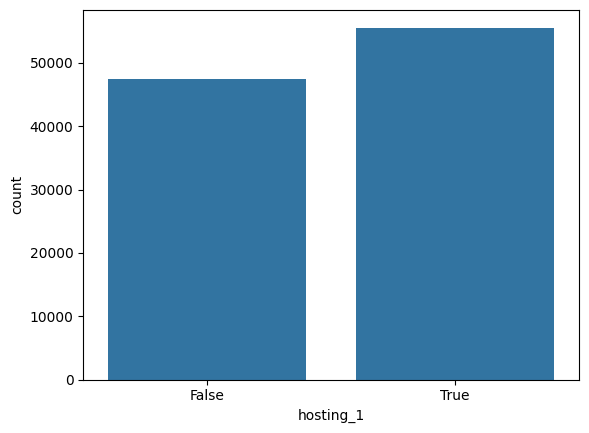

In [ ]:
# Kategorik değişkenlerin hedef değişken ile ilişkisinin incelenmesi
def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"HEDEF_ORTALAMA": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")

for col in cat_cols:
    target_summary_with_cat(df, "yellow_cards", col)

# Sayısal değişkenlerin hedef değişken ile ilişkisinin incelenmesi
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

for col in num_cols:
    target_summary_with_num(df, "yellow_cards", col)

# Sayısal değişkenlerin özeti ve görselleştirilmesi
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)
    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

for col in num_cols:
    num_summary(df, col, plot=True)
    # Kategorik değişkenlerin özeti ve görselleştirilmesi
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].
                        value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)

for col in cat_cols:
    cat_summary(df, col, plot=True)

**Korelasyon Analizi**

---



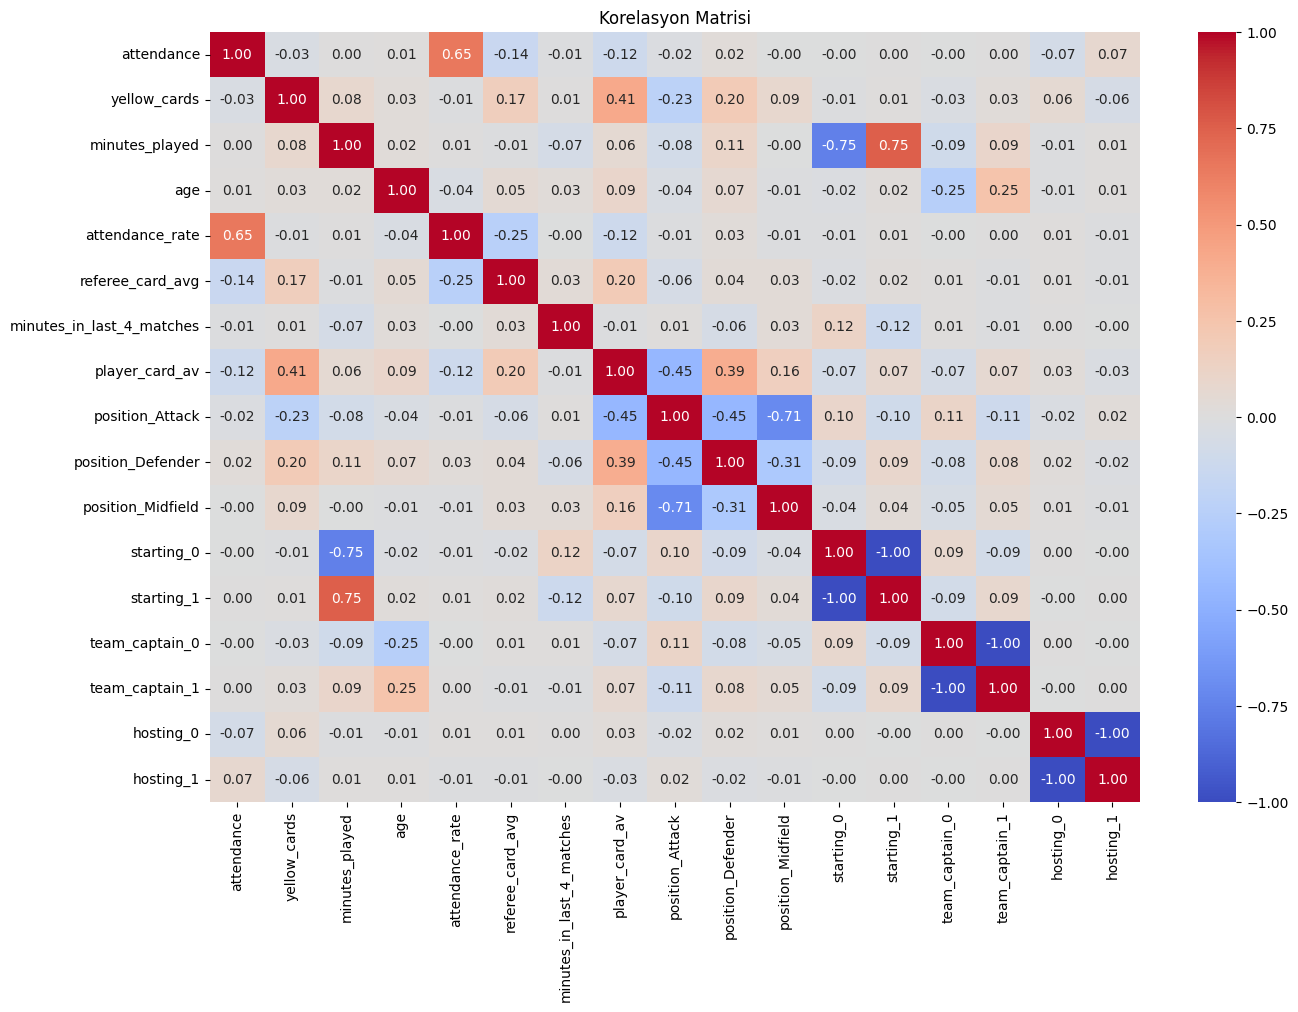

In [ ]:
# prompt: korelasyon analizi ve görselleştirme yap

import matplotlib.pyplot as plt
# Korelasyon analizi
corr = df.corr()

# Korelasyon matrisinin ısı haritası
plt.figure(figsize=(15, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Korelasyon Matrisi")
plt.show()


**Eğitim ve Test Verisi Ayrımı**

---




In [ ]:
# Aşama 4: Veriyi eğitim ve test setlerine ayırma
print("Aşama 4: Veri eğitim ve test setlerine ayrılıyor...")
start_time = time.time()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print(f"Aşama 4: Veri eğitim ve test setlerine ayrıldı ({time.time() - start_time:.2f} saniye)")

Aşama 4: Veri eğitim ve test setlerine ayrılıyor...
Aşama 4: Veri eğitim ve test setlerine ayrıldı (0.02 saniye)


**Sentetik Veri Oluşturma**

---



In [ ]:
 # Aşama 5: SMOTE ile oversampling yapma
print("Aşama 5: SMOTE ile oversampling yapılıyor...")
start_time = time.time()
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
print(f"Aşama 5: SMOTE ile oversampling tamamlandı ({time.time() - start_time:.2f} saniye)")




Aşama 5: SMOTE ile oversampling yapılıyor...
Aşama 5: SMOTE ile oversampling tamamlandı (0.35 saniye)


**Standartlaştırma**

---



In [ ]:
# Aşama 6: Veriyi standardize etme
print("Aşama 6: Veri standardize ediliyor...")
start_time = time.time()
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print(f"Aşama 6: Veri standardize edildi ({time.time() - start_time:.2f} saniye)")

Aşama 6: Veri standardize ediliyor...
Aşama 6: Veri standardize edildi (0.07 saniye)


**Modellerin Tanımlanması**

---



In [ ]:
# Aşama 7: Modelleri tanımlama
print("Aşama 7: Modeller tanımlanıyor...")
models = {
  'Logistic Regression': LogisticRegression(random_state=42),
  'Decision Tree': DecisionTreeClassifier(random_state=42),
  'Random Forest': RandomForestClassifier(random_state=42),
  'XGBoost': XGBClassifier(random_state=42),
  'KNeighbors': KNeighborsClassifier(),
}
print("Aşama 7: Modeller tanımlandı")

Aşama 7: Modeller tanımlanıyor...
Aşama 7: Modeller tanımlandı


**Modellerin Eğitilmesi ve Performans Değerlendirme**

---



Aşama 8: Modeller eğitiliyor ve değerlendiriliyor...
Logistic Regression: Eğitim ve değerlendirme tamamlandı (1.52 saniye)
Decision Tree: Eğitim ve değerlendirme tamamlandı (5.52 saniye)
Random Forest: Eğitim ve değerlendirme tamamlandı (109.79 saniye)
XGBoost: Eğitim ve değerlendirme tamamlandı (2.79 saniye)
KNeighbors: Eğitim ve değerlendirme tamamlandı (3.92 saniye)


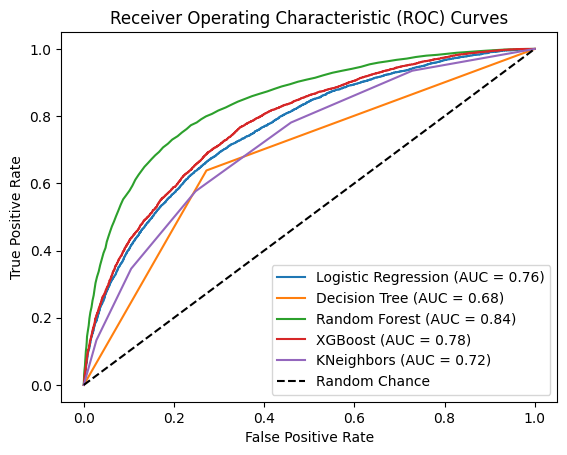

                     accuracy  precision  recall  F1 Skoru  ROC AUC  CV F1 Score
Logistic Regression     0.717      0.710   0.717     0.708    0.763        0.739
Decision Tree           0.694      0.700   0.694     0.696    0.683        0.716
Random Forest           0.782      0.780   0.782     0.781    0.843        0.799
XGBoost                 0.722      0.717   0.722     0.718    0.779        0.751
KNeighbors              0.686      0.685   0.686     0.685    0.723        0.729
Aşama 8: Modeller eğitildi ve değerlendirildi


In [ ]:
# Aşama 8: Modelleri eğitme ve değerlendirme
from sklearn.metrics import roc_auc_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score


print("Aşama 8: Modeller eğitiliyor ve değerlendiriliyor...")
results = {}
for model_name, model in models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_probs = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)
    auc = roc_auc_score(y_test, y_probs)

    # ROC eğrisi
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.2f})')

    # Cross-validation score
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_weighted')

    results[model_name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'F1 Skoru': f1,
        'ROC AUC': auc,
        'CV F1 Score': np.mean(cv_scores)
    }

    elapsed_time = time.time() - start_time
    print(f"{model_name}: Eğitim ve değerlendirme tamamlandı ({elapsed_time:.2f} saniye)")
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='best')
plt.show()

results_df = pd.DataFrame(results).T
print(results_df)
print("Aşama 8: Modeller eğitildi ve değerlendirildi")


**Hiperparametre Bulma**

---



In [ ]:
# Aşama 9: En iyi modeli belirleme
print("Aşama 9: En iyi model belirleniyor...")
best_model_name = results_df['F1 Skoru'].idxmax()
best_model = models[best_model_name]
print(f"Aşama 9: En iyi model belirlendi ({best_model_name})")

Aşama 9: En iyi model belirleniyor...
Aşama 9: En iyi model belirlendi (Random Forest)


In [ ]:
# Aşama 10: GridSearchCV ile en iyi hiperparametreleri bulma
from sklearn.model_selection import GridSearchCV

print(f"Aşama 10: GridSearchCV ile {best_model_name} için en iyi hiperparametreler bulunuyor...")
start_time = time.time()

if best_model_name == 'Logistic Regression':
    param_grid = {
        'penalty': ['l1', 'l2', 'elasticnet', 'none'],
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    }
elif best_model_name == 'Decision Tree':
    param_grid = {
        'criterion': ['gini', 'entropy', 'log_loss'],
        'splitter': ['best', 'random'],
        'max_depth': [None, 10, 20, 30, 40, 50],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
elif best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [200],
        'criterion': ['entropy'],
        'max_depth': [None],
        'min_samples_split': [2],
        'min_samples_leaf': [1]
    }
elif best_model_name == 'XGBoost':
    param_grid = {
        'n_estimators': [100, 200, 300, 400, 500],
        'max_depth': [3, 6, 9, 12, 15],
        'learning_rate': [0.01, 0.1, 0.2, 0.3],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0]
    }
elif best_model_name == 'KNeighbors':
    param_grid = {
        'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    }

# Olasılık sayısını hesaplama ve yazdırma
param_grid_length = np.prod([len(v) for v in param_grid.values()])
print(f"{best_model_name} için {param_grid_length} farklı hiperparametre olasılığı deneniyor...")

grid_search = GridSearchCV(best_model, param_grid, cv=10, scoring='f1_weighted')
grid_search.fit(X_train, y_train)
print(f"Aşama 10: GridSearchCV tamamlandı ({time.time() - start_time:.2f} saniye)")

print("En iyi parametreler: ", grid_search.best_params_)

Aşama 10: GridSearchCV ile Random Forest için en iyi hiperparametreler bulunuyor...
Random Forest için 1 farklı hiperparametre olasılığı deneniyor...
Aşama 10: GridSearchCV tamamlandı (513.64 saniye)
En iyi parametreler:  {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


**Model Seçimi**

---



In [ ]:
# Aşama 11: En iyi modeli kullanarak tahmin yapma
print("Aşama 11: En iyi model ile tahminler yapılıyor...")
start_time = time.time()
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(f"Aşama 11: En iyi model ile tahminler tamamlandı ({time.time() - start_time:.2f} saniye)")

Aşama 11: En iyi model ile tahminler yapılıyor...
Aşama 11: En iyi model ile tahminler tamamlandı (1.32 saniye)


**Performans Değerlendirme**

---



In [ ]:
# Aşama 12: Sonuçları değerlendirme
print("Aşama 12: Sonuçlar değerlendiriliyor...")
print("Model doğruluğu: ", accuracy_score(y_test, y_pred))
print("Sınıflandırma raporu: \n", classification_report(y_test, y_pred))

Aşama 12: Sonuçlar değerlendiriliyor...
Model doğruluğu:  0.7835556633519282
Sınıflandırma raporu: 
               precision    recall  f1-score   support

           0       0.82      0.84      0.83     12831
           1       0.73      0.69      0.71      7784

    accuracy                           0.78     20615
   macro avg       0.77      0.76      0.77     20615
weighted avg       0.78      0.78      0.78     20615



**Karmaşıklık Matrisi**

---



Aşama 13: Confusion Matrix oluşturuluyor ve görselleştiriliyor...


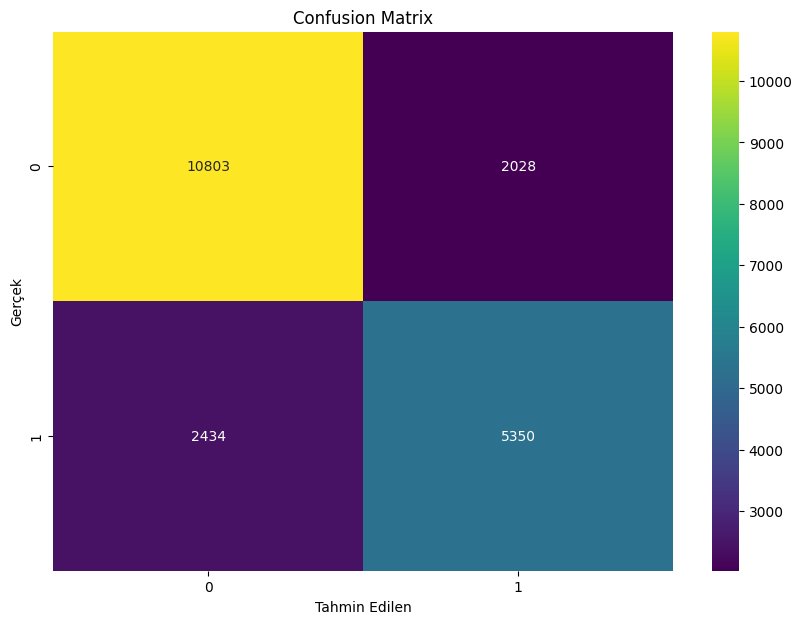

Aşama 13: Confusion Matrix oluşturuldu ve görüntülendi (0.19 saniye)


In [ ]:
# Aşama 13: Confusion Matrix oluşturma ve görselleştirme
print("Aşama 13: Confusion Matrix oluşturuluyor ve görselleştiriliyor...")
start_time = time.time()
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
plt.title('Confusion Matrix')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.show()
print(f"Aşama 13: Confusion Matrix oluşturuldu ve görüntülendi ({time.time() - start_time:.2f} saniye)")

**Değişken Önceliklendirme**

---



Aşama 14: Özelliklerin Önemi Hesaplanıyor...


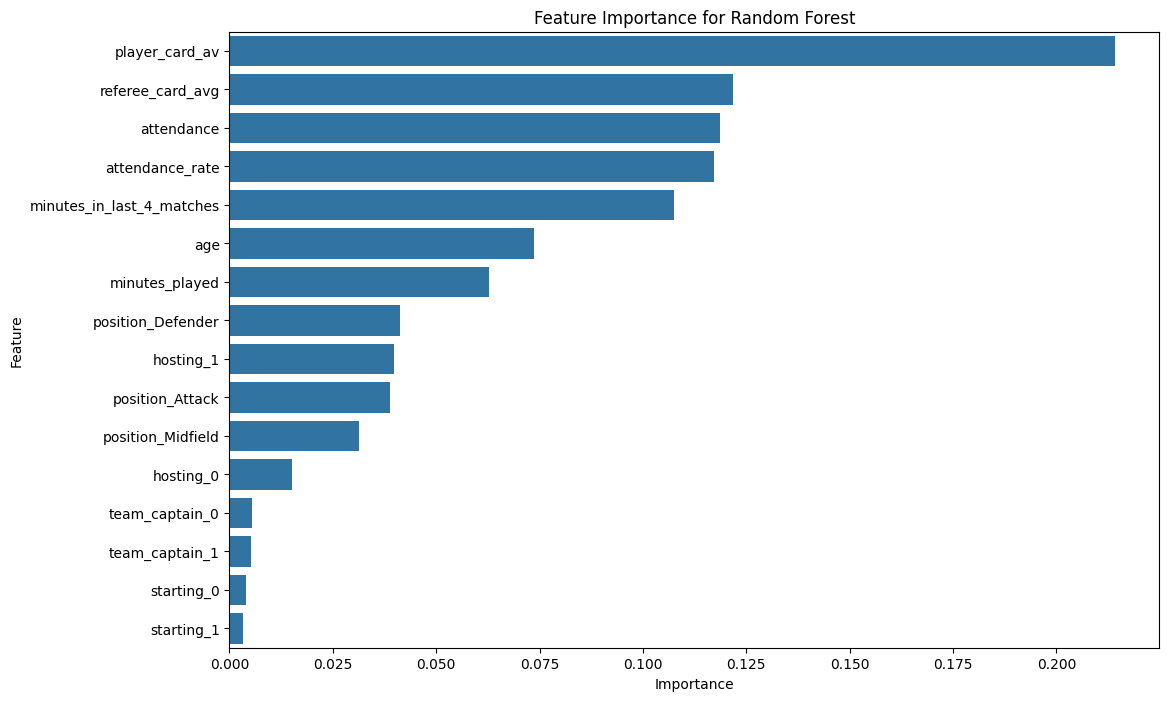

                      Feature  Importance
6              player_card_av       0.214
4            referee_card_avg       0.122
0                  attendance       0.119
3             attendance_rate       0.117
5   minutes_in_last_4_matches       0.107
2                         age       0.074
1              minutes_played       0.063
8           position_Defender       0.041
15                  hosting_1       0.040
7             position_Attack       0.039
9           position_Midfield       0.031
14                  hosting_0       0.015
12             team_captain_0       0.006
13             team_captain_1       0.005
10                 starting_0       0.004
11                 starting_1       0.003
Aşama 13: Özelliklerin Önemi Hesaplandı (0.47 saniye)
Toplam süre: 0.47 saniye
Toplam süre: 0.47 saniye


In [ ]:
# Aşama 14: Feature Importance
print("Aşama 14: Özelliklerin Önemi Hesaplanıyor...")
start_time = time.time()
start_total_time = time.time()
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    feature_names = pd.get_dummies(pd.DataFrame(X), drop_first=True).columns  # Feature names after OHE
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
    plt.title(f'Feature Importance for {best_model_name}')
    plt.show()
    print(feature_importance_df)
else:
    print(f"{best_model_name} modeli için özellik önemi hesaplanamıyor.")
print(f"Aşama 13: Özelliklerin Önemi Hesaplandı ({time.time() - start_time:.2f} saniye)")
print(f"Toplam süre: {time.time() - start_total_time:.2f} saniye")
print(f"Toplam süre: {time.time() - start_total_time:.2f} saniye")

**Örnek Veri Giriş ve Sonuç Tahmini**

---



**03.08.24 GS-BJK SÜPERKUPA FİNAL MAÇI VERİLERİ**

---



In [ ]:
df_= pd.read_csv("test.csv")
df_.head)

,yellow_cards,attendance,minutes_played,age,attendance_rate,referee_card_avg,minutes_in_last_4_matches,player_card_av,position_Attack,position_Defender,position_Midfield,starting_0,starting_1,team_captain_0,team_captain_1,hosting_0,hosting_1
0,0,70847,96,37,0.910,5.080,360,0.000,0,0,0,1,0,0,1,0,0
1,0,70847,96,25,0.910,5.080,351,0.000,0,1,0,1,0,1,0,0,0
2,0,70847,96,29,0.910,5.080,343,0.000,0,1,0,1,0,1,0,0,0
3,0,70847,87,26,0.910,5.080,257,9.090,0,1,0,1,0,1,0,0,0
4,0,70847,96,29,0.910,5.080,267,0.000,0,1,0,1,0,1,0,0,0


In [ ]:
from sklearn.preprocessing import StandardScaler
from google.colab import files

# Kullanıcıdan CSV dosyasını yüklemesini iste
uploaded = files.upload()

# Yüklenen dosyanın adını al
filename = next(iter(uploaded))

# CSV dosyasını DataFrame'e yükle
try:
    test_df = pd.read_csv(filename)
except Exception as e:
    print(f"Hata: CSV dosyası yüklenirken bir hata oluştu: {e}")
    exit()

# Eğitim verilerinde kullanılan özniteliklerle aynı öznitelikleri seç
X_test_new = test_df[X.columns]

# Kategorik öznitelikleri one-hot encoding ile dönüştür
X_test_new = pd.get_dummies(X_test_new, columns=["position_Attack", "position_Defender", "position_Midfield", 'minutes_played', 'team_captain_1', 'team_captain_0', 'hosting_0', 'hosting_1'])

# Eksik sütunları ekle ve 0 ile doldur (eğitim verilerinde olmayan sütunlar için)
missing_cols = set(X.columns) - set(X_test_new.columns)
for col in missing_cols:
    X_test_new[col] = 0
X_test_new = X_test_new[X.columns]  # Sütun sırasını eğitim verileriyle aynı yap

# Eğitim verileri için scaler'ı uygun şekilde fit et
scaler = StandardScaler()
scaler.fit(X_train)  # X_train, eğitim veri setinizin özelliklerini içermelidir

# Veriyi ölçeklendir
X_test_new = scaler.transform(X_test_new)

# Modelin olasılık tahminlerini al
probabilities = best_model.predict_proba(X_test_new)[:, 1]

# Karar eşiğini ayarla (örneğin, 0.6 olarak ayarlıyoruz)
threshold = 1
predictions = (probabilities >= threshold).astype(int)

# Tahmin sonuçlarını yazdır
for i, prediction in enumerate(predictions):
    print(f"Oyuncu {i+1}: {'Sarı Kart Alabilir' if prediction == 1 else 'Sarı Kart Almayabilir'}")



Saving test.csv to test (7).csv
Oyuncu 1: Sarı Kart Almayabilir
Oyuncu 2: Sarı Kart Almayabilir
Oyuncu 3: Sarı Kart Almayabilir
Oyuncu 4: Sarı Kart Almayabilir
Oyuncu 5: Sarı Kart Almayabilir
Oyuncu 6: Sarı Kart Almayabilir
Oyuncu 7: Sarı Kart Almayabilir
Oyuncu 8: Sarı Kart Almayabilir
Oyuncu 9: Sarı Kart Almayabilir
Oyuncu 10: Sarı Kart Almayabilir
Oyuncu 11: Sarı Kart Almayabilir
Oyuncu 12: Sarı Kart Almayabilir
Oyuncu 13: Sarı Kart Almayabilir
Oyuncu 14: Sarı Kart Almayabilir
Oyuncu 15: Sarı Kart Almayabilir
Oyuncu 16: Sarı Kart Almayabilir
Oyuncu 17: Sarı Kart Almayabilir
Oyuncu 18: Sarı Kart Almayabilir
Oyuncu 19: Sarı Kart Almayabilir
Oyuncu 20: Sarı Kart Almayabilir
Oyuncu 21: Sarı Kart Almayabilir
Oyuncu 22: Sarı Kart Almayabilir
Oyuncu 23: Sarı Kart Almayabilir
Oyuncu 24: Sarı Kart Almayabilir
Oyuncu 25: Sarı Kart Almayabilir
Oyuncu 26: Sarı Kart Almayabilir
Oyuncu 27: Sarı Kart Almayabilir
Oyuncu 28: Sarı Kart Almayabilir
Oyuncu 29: Sarı Kart Almayabilir
Oyuncu 30: Sarı Kart

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [ ]:
def predict_yellow_cards(main_pipeline, train_file_path, test_file_path):
    # Ana pipeline fonksiyonunu çalıştırarak en iyi modeli ve scaler'ı elde edin
    best_model, scaler = main_pipeline(train_file_path)

    # Test veri setini yükleyin
    df_test = pd.read_csv(test_file_path)

    # Bağımsız değişkenleri (X_test) hazırlayın
    X_test = df_test

    # X_test'i standardize edin (pipeline fonksiyonunda yapılan işlemlere uygun olarak)
    X_test = scaler.transform(X_test)

    # En iyi modelle tahmin yapın
    y_pred = best_model.predict(X_test)

    # Tahmin sonuçlarını ekleyin ve döndürün
    df_test['predicted_yellow_cards'] = y_pred
    return df_test


# Eğitim veri seti dosya yolu
train_file_path = "final_Project/model_verisi.csv"
test_file_path = 'final_Project/gs_bjk/test.csv'

tes = pd.read_csv("final_Project/gs_bjk/test.csv")

# Tahmin fonksiyonunu çağırarak tahminleri elde edin
predicted_df = predict_yellow_cards(main_pipeline, train_file_path, test_file_path)

# Tahmin sonuçlarını yazdırın veya kaydedin
print(predicted_df)
predicted_df.to_csv('final_Project/gs_bjk/cıktı.csv', index=False)
# Modeli dışarı aktarma
import joblib
joblib.dump(main_pipeline, 'final_Project/modelleme_pipline.pkl')

a = pd.read_csv('final_Project/gs_bjk/cıktı.csv')
b = pd.read_csv('final_Project/gs_bjk/gercek.csv')

# a veri setindeki predicted_yellow_cards ile b veri setindeki yellow_card değişkenlerini karşılaştır
a["predicted_yellow_cards"] == b["yellow_card"]

c = a["predicted_yellow_cards"] == b["yellow_card"]
print(c.value_counts(normalize=True))

# Modelin doğruluğu
print("Model doğruluğu: ", accuracy_score(b["yellow_card"], a["predicted_yellow_cards"]))

c = pd.DataFrame(c)
c = ()

c["predicted_yellow_cards"] = a["predicted_yellow_cards"]
c["yellow_card"] = b["yellow_card"]
c["test"] = c["predicted_yellow_cards"] == c["yellow_card"]